In [ ]:
!pip install albumentations
!pip install --upgrade albumentations

In [ ]:

#mount google drive
from google.colab import drive
drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizer_v1 import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import os
import numpy as np
import pandas as pd
import albumentations
import cv2
%matplotlib inline

In [ ]:
!rm unidro -r
#copy the data from google drive to unidro folder in our workspace
import pathlib
pathlib.os.mkdir("unidro")
!cp drive/MyDrive/unidro/data_unidro.zip drive/MyDrive/unidro/labels.zip ./unidro
pathlib.os.chdir("./unidro/")
!unzip data_unidro.zip
#back up the old labels
!mkdir old_labels && mv from-to-rqd.xlsx label.xlsx old_labels
#get the new labels
!unzip labels.zip
!ls

In [ ]:
#load the excel files

df_ftr = pd.read_excel("from-to-rqd.xlsx")
df_label = pd.read_excel("label.xlsx")
df_ftr.head()

,RunId,from,to
0,M3-BH3299-1-1,0.0,2.2
1,M3-BH3299-1-2,2.2,3.3
2,M3-BH3299-1-3,3.3,4.4
3,M3-BH3299-2-1,4.4,4.9
4,M3-BH3299-2-2,4.9,6.5


In [ ]:
df_label.head()

,image_name,label_name,xmin,ymin,width,height,image_width,image_height
0,M3-BH130-1.jpg,wood,2412,1552,152,197,4020,2929
1,M3-BH130-1.jpg,wood,2917,2072,140,220,4020,2929
2,M3-BH130-1.jpg,wood,3820,1567,167,209,4020,2929
3,M3-BH130-1.jpg,wood,3603,2341,201,186,4020,2929
4,M3-BH130-1.jpg,wood,1676,2713,159,171,4020,2929


In [ ]:
#read the train images from ./train/ folder

train_images_name = pathlib.os.listdir("./train/")
N = len(train_images_name)
train_images = [cv2.cvtColor(cv2.imread(f"./train/{x}"), cv2.COLOR_BGR2RGB) for x in train_images_name]

print(len(train_images), N)

156 156


In [ ]:
#function to change the size of images and bounding boxes with albumnetations library

def resize_image(img_arr, bboxes, w, h):
    """
    :param img_arr: original image as a numpy array
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'width', 'height', "class label"
    :param h: resized height dimension of image
    :param w: resized weight dimension of image
    :return: dictionary containing {image:transformed, bboxes:['x_min', 'y_min', 'width', 'height', "class label"]}
    """
    # create resize transform pipeline
    transform = albumentations.Compose(
        [albumentations.Resize(height=h, width=w, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='coco'))

    transformed = transform(image=img_arr, bboxes=bboxes)

    return transformed


In [ ]:
def augmen_hp(img_arr, bbox):
  transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=0.5)],
    bbox_params=albumentations.BboxParams(format='coco')
)
  transformed = transform(image=img_arr, bboxes=bbox)
  return transformed


In [ ]:
# def augmen_vp(img_arr, bbox):
#   transform = albumentations.Compose(
#     [albumentations.VerticalFlip(p=0.5)],
#     bbox_params=albumentations.BboxParams(format='coco')
# )
#   transformed = transform(image=img_arr, bboxes=bbox)
#   return transformed


In [ ]:
#get each picture bounding boxes form df_labels
labels_each_image = []
for t in train_images_name:
  l = df_label[["xmin", "ymin", "width", "height", "label_name"]][df_label["image_name"].apply(lambda x:x.lower()) == t.lower()]
  labels_each_image.append(l.to_numpy())

In [ ]:
#fix each image width and height and change the bounding boxes coordinates accordingly

fixed_width, fixed_height = 480, 480
resized_train_images = []
resized_bbox_labels = []
for i in range(len(train_images)):
  tr_dict = resize_image(train_images[i], labels_each_image[i], fixed_width, fixed_height)
  tr_hflip = augmen_hp(tr_dict["image"], tr_dict["bboxes"])
  # tr_vflip = augmen_vp(tr_dict["image"], tr_dict["bboxes"])

  resized_train_images.append(tr_dict["image"])
  resized_train_images.append(tr_hflip["image"])
  # resized_train_images.append(tr_vflip["image"])
  bbox = albumentations.augmentations.bbox_utils.convert_bboxes_to_albumentations(tr_dict["bboxes"], "coco", fixed_width, fixed_height)
  bbox = albumentations.augmentations.bbox_utils.convert_bboxes_from_albumentations(bbox, "pascal_voc", fixed_width, fixed_height)
  resized_bbox_labels.append(bbox)
  
  bbox = albumentations.augmentations.bbox_utils.convert_bboxes_to_albumentations(tr_hflip["bboxes"], "coco", fixed_width, fixed_height)
  bbox = albumentations.augmentations.bbox_utils.convert_bboxes_from_albumentations(bbox, "pascal_voc", fixed_width, fixed_height)
  resized_bbox_labels.append(bbox)

  # bbox = albumentations.augmentations.bbox_utils.convert_bboxes_to_albumentations(tr_vflip["bboxes"], "coco", fixed_width, fixed_height)
  # bbox = albumentations.augmentations.bbox_utils.convert_bboxes_from_albumentations(bbox, "pascal_voc", fixed_width, fixed_height)
  # resized_bbox_labels.append(bbox)

del train_images
del labels_each_image

In [ ]:
N = len(resized_bbox_labels)

In [ ]:
N

312

In [ ]:
class_ids = df_label["label_name"].unique()
num_classes = len(class_ids)
print(num_classes, class_ids)

2 ['wood' '+10cm rock']


In [ ]:
NORM_H, NORM_W = 480, 480
GRID_H, GRID_W = 10 , 10
BATCH_SIZE = 8
BOX = 2
ORIG_CLASS = 2

THRESHOLD = 0.5
# ANCHORS = '1.08,1.19'
ANCHORS = '2.5, 0.5, 1.0, 1.1'
ANCHORS = [float(ANCHORS.strip()) for ANCHORS in ANCHORS.split(',')]
SCALE_NOOB, SCALE_CONF, SCALE_COOR, SCALE_PROB = 0.5, 5.0, 5.0, 1.0


In [ ]:
print(np.array(ANCHORS).shape)

(2,)


In [ ]:

def yolo_label(bboxes):
  """ 
    function to convert the bboxes to yolo labels
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'width', 'height', "class_label" 
  """
  labels = np.zeros((GRID_W, GRID_H, BOX,1 + 4 + num_classes), dtype='d')
  for b in bboxes:
    x_min, y_min, x_max, y_max = b[0:4]
    width = x_max - x_min
    height = y_max - y_min
    bx = round(x_min + width / 2)
    by = round(y_min + height / 2)
    loc_x = (GRID_W * bx) // fixed_width
    loc_y = (GRID_H * by) // fixed_height
    loc_c = 5 if b[4] == class_ids[0] else 6
    labels[loc_x, loc_y, :, 0] = x_min
    labels[loc_x, loc_y, :, 1] = y_min
    labels[loc_x, loc_y, :, 2] = x_max
    labels[loc_x, loc_y, :, 3] = y_max
    labels[loc_x, loc_y, :, 4] = 1.0
    labels[loc_x, loc_y, :, loc_c] = 1.0
  return  labels

In [ ]:
y = np.zeros((N, GRID_W, GRID_H, BOX, 1 + 4 + num_classes), dtype='d')
for i in range(N):
  y[i, :, :, :, :] = yolo_label(resized_bbox_labels[i])

In [ ]:
y.shape

(312, 10, 10, 2, 7)

In [ ]:
X = np.asarray(resized_train_images)
del resized_train_images
X.shape

(312, 480, 480, 3)

In [ ]:
model = Sequential()

# Layer 1
model.add(Conv2D(16, (3,3), strides=(1,1), padding='valid', use_bias=False, input_shape=(480,480,3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(3, 3), padding="same"))

# Layer 2 - 5
for i in range(0,4):
    model.add(Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))

# Layer 7 - 8
for _ in range(0,2):
    model.add(Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dropout(0.5))
# Layer 9
model.add(Conv2D(BOX * (4 + 1 + ORIG_CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal', padding="valid"))
model.add(Activation('linear'))
model.add(Reshape((GRID_H, GRID_W, BOX, 4 + 1 + ORIG_CLASS)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 478, 478, 16)      432       
_________________________________________________________________
batch_normalization_16 (Batc (None, 478, 478, 16)      64        
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 478, 478, 16)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 160, 160, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 160, 160, 32)      4608      
_________________________________________________________________
batch_normalization_17 (Batc (None, 160, 160, 32)      128       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 160, 160, 32)     

In [ ]:
CLASS = 2

In [ ]:
def custom_loss(y_true, y_pred):
    ### Adjust prediction
    # adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
    # adjust w and h
    pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
    
    # adjust probability
    pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
    
    y_pred = tf.concat([pred_box_xy, pred_box_wh, pred_box_conf, pred_box_prob], 4)
    print("Y_pred shape: {}".format(y_pred.shape))
    
    ### Adjust ground truth
    # adjust x and y
    center_xy = .5*(y_true[:,:,:,:,0:2] + y_true[:,:,:,:,2:4])
    center_xy = center_xy / np.reshape([(float(NORM_W)/GRID_W), (float(NORM_H)/GRID_H)], [1,1,1,1,2])
    true_box_xy = center_xy - tf.floor(center_xy)
    
    # adjust w and h
    true_box_wh = (y_true[:,:,:,:,2:4] - y_true[:,:,:,:,0:2])
    true_box_wh = tf.sqrt(true_box_wh / np.reshape([float(NORM_W), float(NORM_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
    pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
    pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
    
    true_tem_wh = tf.pow(true_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    true_box_area = true_tem_wh[:,:,:,:,0] * true_tem_wh[:,:,:,:,1]
    true_box_ul = true_box_xy - 0.5 * true_tem_wh
    true_box_bd = true_box_xy + 0.5 * true_tem_wh
    
    intersect_ul = tf.maximum(pred_box_ul, true_box_ul) 
    intersect_br = tf.minimum(pred_box_bd, true_box_bd)
    intersect_wh = intersect_br - intersect_ul
    intersect_wh = tf.maximum(intersect_wh, 0.0)
    intersect_area = intersect_wh[:,:,:,:,0] * intersect_wh[:,:,:,:,1]
    
    iou = tf.truediv(intersect_area, true_box_area + pred_box_area - intersect_area)
    best_box = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box = tf.cast(best_box, tf.float32)
    true_box_conf = tf.expand_dims(best_box * y_true[:,:,:,:,4], -1)
    
    # adjust confidence
    true_box_prob = y_true[:,:,:,:,5:]
    
    y_true = tf.concat([true_box_xy, true_box_wh, true_box_conf, true_box_prob], 4)
    print("Y_true shape: {}".format(y_true.shape))
    #y_true = tf.Print(y_true, [true_box_wh], message='DEBUG', summarize=30000)    
    
    ### Compute the weights
    weight_coor = tf.concat(4 * [true_box_conf], 4)
    weight_coor = SCALE_COOR * weight_coor
    
    weight_conf = SCALE_NOOB * (1. - true_box_conf) + SCALE_CONF * true_box_conf
    
    weight_prob = tf.concat(CLASS * [true_box_conf], 4) 
    weight_prob = SCALE_PROB * weight_prob 
    
    weight = tf.concat([weight_coor, weight_conf, weight_prob], 4)
    print("Weight shape: {}".format(weight.shape))
    
    ### Finalize the loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight
    loss = tf.reshape(loss, [-1, GRID_W*GRID_H*BOX*(4 + 1 + CLASS)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)
    
    return loss

In [ ]:
# early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
# checkpoint = ModelCheckpoint('weights2.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)

In [ ]:
import tensorflow as tf

In [ ]:
indx_valid = np.random.permutation(range(N))[:12]

In [ ]:
indx_valid

array([ 91, 200, 230,  53, 288, 206, 215, 155, 151,  72,  88, 291])

In [ ]:
indx_train = list(range(N))
for a in indx_valid:
  indx_train.remove(a)

In [ ]:
X_train, y_train = X[indx_train] / 255.0, y[indx_train]
X_valid, y_valid = X[indx_valid] / 255.0, y[indx_valid]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(48).batch(BATCH_SIZE)

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.00001, decay=0.0005, momentum=0.9)
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=custom_loss, optimizer=sgd)

In [ ]:
model.fit(dataset, validation_data=(X_valid, y_valid),
                    epochs = 100, 
                    verbose = 2)

Epoch 1/100
Y_pred shape: (None, 10, 10, 2, 7)
Y_true shape: (None, 10, 10, 2, 7)
Weight shape: (None, 10, 10, 2, 7)
Y_pred shape: (None, 10, 10, 2, 7)
Y_true shape: (None, 10, 10, 2, 7)
Weight shape: (None, 10, 10, 2, 7)
Y_pred shape: (None, 10, 10, 2, 7)
Y_true shape: (None, 10, 10, 2, 7)
Weight shape: (None, 10, 10, 2, 7)
38/38 - 7s - loss: 36.8435 - val_loss: 28.1188
Epoch 2/100
38/38 - 5s - loss: 30.5944 - val_loss: 27.3811
Epoch 3/100
38/38 - 5s - loss: 28.6155 - val_loss: 27.2126
Epoch 4/100
38/38 - 5s - loss: 27.3336 - val_loss: 27.3514
Epoch 5/100
38/38 - 5s - loss: 26.1619 - val_loss: 27.2813
Epoch 6/100
38/38 - 5s - loss: 25.2906 - val_loss: 27.3728
Epoch 7/100
38/38 - 5s - loss: 24.4497 - val_loss: 27.4629
Epoch 8/100
38/38 - 5s - loss: 24.0376 - val_loss: 26.9623
Epoch 9/100
38/38 - 5s - loss: 23.1728 - val_loss: 26.5629
Epoch 10/100
38/38 - 5s - loss: 22.8636 - val_loss: 25.7158
Epoch 11/100
38/38 - 5s - loss: 22.1743 - val_loss: 25.0689
Epoch 12/100
38/38 - 5s - loss: 21

In [ ]:
from matplotlib import patches

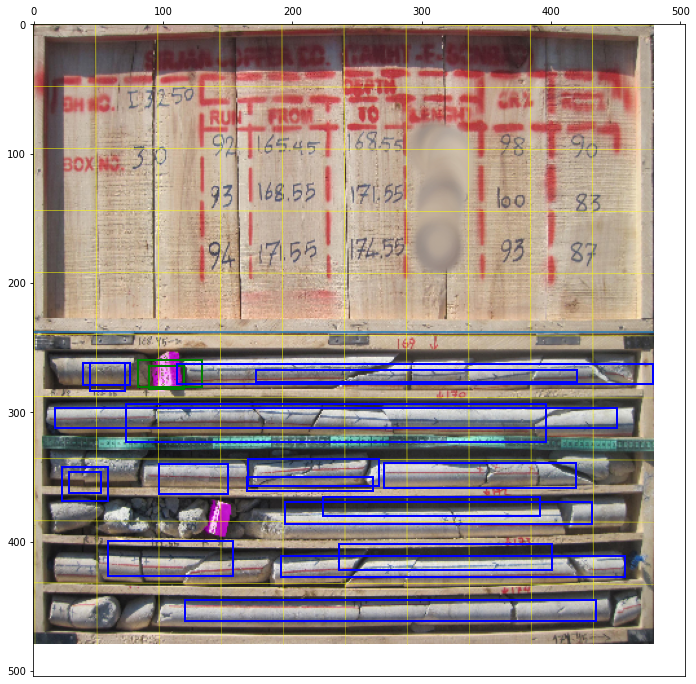

In [ ]:
m = 200
# visualize grids
# S = number of grids
S = 10
fig, ax = plt.subplots(figsize = (12,12))
thresh_hold = 0.7
ax.imshow(X_train[m])
ax.xaxis.tick_top()
ax.plot(range(0, fixed_height), [fixed_height // 2 - 2] * fixed_height)

for i in range(0, fixed_height, fixed_height // S):
  ax.add_patch(patches.Arrow(i, 0, 1, fixed_height, fill=False, edgecolor='yellow', lw=0.25))
  ax.add_patch(patches.Arrow(0, i, fixed_width, 1, fill=False, edgecolor='yellow', lw=0.25))


# for row in range(GRID_W):
#   for col in range(GRID_H):
#     if y_train[m, row, col, 0, 4] >= 0.5:
#       x_min, y_min, x_max, y_max = y_train[m, row, col, 0, :4]
#       w = x_max - x_min
#       h = y_max - y_min
#       x = x_min
#       y = y_min
      
#       ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))
    
y_pred = model(np.expand_dims(X_train[m], 0))
pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
# adjust w and h
pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
  
pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2])
pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
y_pred = tf.concat([pred_box_xy, pred_tem_wh, pred_box_conf, pred_box_prob], 4)

thresh_hold = 0.7

for row in range(GRID_W):
  for col in range(GRID_H):
    
    if y_pred[0, row, col, 0, 4] >= thresh_hold:
      x_min, y_min, w, h = y_pred[0, row, col, 0, :4]
      w = w.numpy() * 48
      h = h.numpy() * 48
      x = (x_min.numpy() + row) * fixed_width / GRID_W
      y = (y_min.numpy() + col) * fixed_height / GRID_H
      c = np.argmax(y_pred[0, row, col, 0, 5:])
      if c == 0:
        ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='green', lw=2))
      else:
        ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='blue', lw=2))

    if y_pred[0, row, col, 1, 4] >= thresh_hold:
      x_min, y_min, w, h = y_pred[0, row, col, 1, :4]
      w = w.numpy() * 48
      h = h.numpy() * 48
      x = (x_min.numpy() + row) * fixed_width / GRID_W
      y = (y_min.numpy() + col) * fixed_height / GRID_H
      c = np.argmax(y_pred[0, row, col, 1, 5:])
      if c == 0:
        ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='green', lw=2))
      else:
        ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='blue', lw=2))
    

# for r in resized_bbox_labels[20]:
#   x, y, w, h = r[0], r[1], r[2], r[3]
#   ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))

In [ ]:
model.save("./model_100_eh")

In [ ]:
model.save_weights("./model_100_eh")

In [ ]:
!zip -r ./model_1_eh.zip model_1_eh

In [ ]:
!cp ./model_1_eh.zip ../drive/MyDrive

In [ ]:
!ls

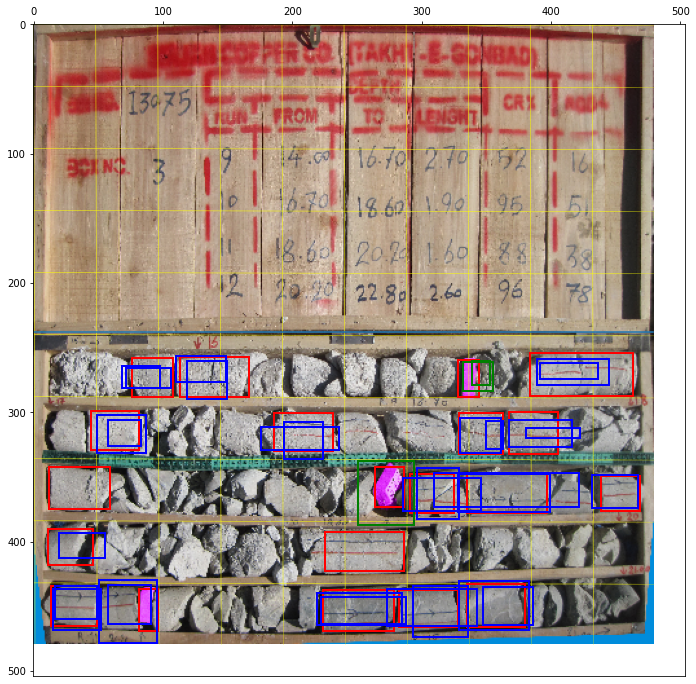

In [ ]:
m = 11
# visualize grids
# S = number of grids
S = 10
fig, ax = plt.subplots(figsize = (12,12))

ax.imshow(X_valid[m])
ax.xaxis.tick_top()
ax.plot(range(0, fixed_height), [fixed_height // 2 - 2] * fixed_height)

for i in range(0, fixed_height, fixed_height // S):
  ax.add_patch(patches.Arrow(i, 0, 1, fixed_height, fill=False, edgecolor='yellow', lw=0.25))
  ax.add_patch(patches.Arrow(0, i, fixed_width, 1, fill=False, edgecolor='yellow', lw=0.25))


for row in range(GRID_W):
  for col in range(GRID_H):
    if y_valid[m, row, col, 0, 4] >= 0.5:
      x_min, y_min, x_max, y_max = y_valid[m, row, col, 0, :4]
      w = x_max - x_min
      h = y_max - y_min
      x_ = x_min
      y_ = y_min
      
      ax.add_patch(patches.Rectangle((x_,y_),w,h, fill=False, edgecolor='red', lw=2))

y_pred = model(np.expand_dims(X_valid[m], 0))
pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
# adjust w and h
pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
  
pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2])
pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
y_pred = tf.concat([pred_box_xy, pred_tem_wh, pred_box_conf, pred_box_prob], 4)

for row in range(GRID_W):
  for col in range(GRID_H):
    
    for j in range(BOX):
      if y_pred[0, row, col, j, 4] >= 0.7:
        x_min, y_min, w, h = y_pred[0, row, col, j, :4]
        w = w.numpy() * 48
        h = h.numpy() * 48
        x = (x_min.numpy() + row) * fixed_width / GRID_W
        y = (y_min.numpy() + col) * fixed_height / GRID_H
        # ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='green', lw=2))
        c = np.argmax(y_pred[0, row, col, j, 5:])
        if c == 0:
          ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='green', lw=2))
        else:
          ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='blue', lw=2))
        
# for r in resized_bbox_labels[20]:
#   x, y, w, h = r[0], r[1], r[2], r[3]
#   ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))

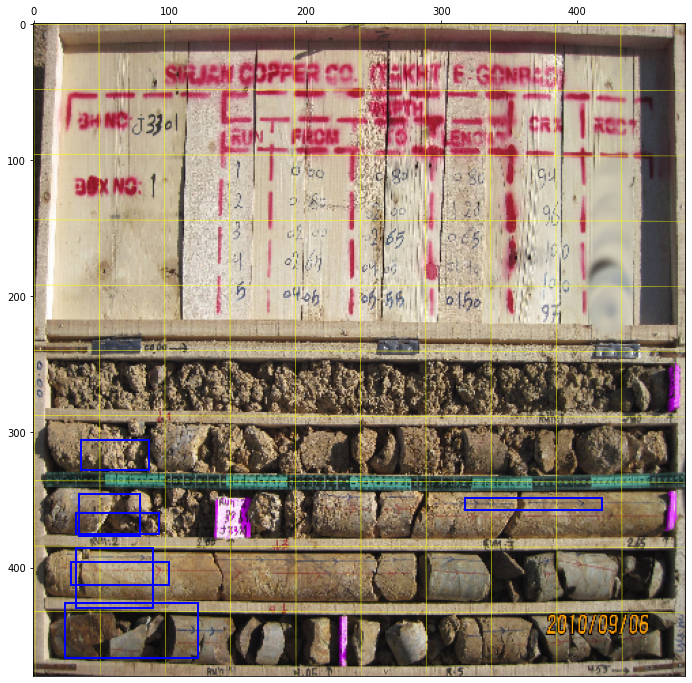

In [ ]:
# visualize grids
# S = number of grids
S = 10
test_im = cv2.cvtColor(cv2.imread("test-rqd/M3-BH3301-1.jpg"), cv2.COLOR_BGR2RGB)
test_im = albumentations.Resize(height=480, width=480, always_apply=True)(image=test_im)
test_im = test_im["image"] / 255.0
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(test_im)
ax.xaxis.tick_top()

for i in range(0, fixed_height, fixed_height // S):
  ax.add_patch(patches.Arrow(i, 0, 1, fixed_height, fill=False, edgecolor='yellow', lw=0.25))
  ax.add_patch(patches.Arrow(0, i, fixed_width, 1, fill=False, edgecolor='yellow', lw=0.25))


y_pred = model(np.expand_dims(test_im, 0))
pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
# adjust w and h
pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
  
pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2])
pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
y_pred = tf.concat([pred_box_xy, pred_tem_wh, pred_box_conf, pred_box_prob], 4)

for row in range(GRID_W):
  for col in range(GRID_H):
    for j in range(BOX):
      if y_pred[0, row, col, j, 4] >= 0.7:
        x_min, y_min, w, h = y_pred[0, row, col, j, :4]
        w = w.numpy() * 48
        h = h.numpy() * 48
        x = (x_min.numpy() + row) * fixed_width / GRID_W
        y = (y_min.numpy() + col) * fixed_height / GRID_H
        # ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='green', lw=2))
        c = np.argmax(y_pred[0, row, col, j, 5:])
        if c == 0:
          ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='green', lw=2))
        else:
          ax.add_patch(patches.Rectangle((x - w/2.0,y - h / 2.0),w,h, fill=False, edgecolor='blue', lw=2))
        